## Q-learning / Reinforcement learning, example 1, FrozenLake, default grid

#### Imports + and make the environment

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import Image
from IPython.display import clear_output
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())


# Actually Agent is a decesion maker its an entiy that actulaly intract with envioirment to achive the required target 
#action = np.argmax(q_table[state, :])
# The envoirment is a world where agent intrect and it provided the states and rewards based on agent actions
# env = gym.make("FrozenLake-v1", is_slippery=False)
# State is current steps or value in the envoirment
# state = env.reset()
# Observation is what the agent sees, its usucally calculation for further movement according to current seen around for further action
# new_state, reward, done, info = env.step(action)
# Rewards, 0 or 1, or you may call it acchivement or failure 
# A policy is agent strategy based on observation
# Along with this Bellman’s Equation provides a recursive relationship for the value of a policy.
#  Q-Learning This helps the agent update its belief about the long-term value of taking a certain action in a certain state
# Q Table will explain later in detail with values and actions as well.
# Exploration is trying new actions to discover their effects (learning).
# Exploitation is choosing the best-known action to maximize rewards (using knowledge).
# alpha learning rate new information overrides old info in the Q-table, 
# gamma Measures how much future rewards are valued vs. immediate rewards
# epsilon is exploration rate and decay How quickly epsilon is reduced each episode.


### This time, we'll use Q-learning and reinforcement learning for the agent (elf) to move in the world!

In [ ]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

In [ ]:
# the above information is used to generate an EMPTY Q-table!
# basically Q-table will hold the Quality-values (Q-values) for each possible action
# for each possible cell in the grid (basically we map out all possibilities in this environment)
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

## Q-learning formula:

#### Q(s, a) = Q(s, a) + alpha * (r + y * max(Q(s', a')) - Q(s, a))

In [ ]:
# let's code the above equation into Q-learning update -function
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q
# Q(s, a) Current estimate of the value (expected future reward) of taking action a in state s.
# Learning rate. Controls how much the Q-value gets updated.
# R immediate rewards with actions, Y is gamma determind regarding how much future rewards does matters.
# max(Q(s′, a′)) It’s the agent’s guess of the maximum future reward from that state
# r + γ * max(Q(s′, a′)): This whole part is the target value: the reward just received + expected future reward.

### Helper function to visualize the highest Q-values in the grid

In [ ]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_width, grid_height)

In [ ]:

# From 10,000 for better convergence
total_episodes = 20000
# gives agent more time to succeed per episode
max_steps = 100
# here avoids overshooting Q-values
learning_rate = 0.4
gamma = 0.92
epsilon = 0.9
# upper bound of our epsilon
max_epsilon = 0.9
# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.01
decay_rate = 0.0004

### Train the agent with a for-loop (based on episodes)

In [ ]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # => we get initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    # WITHIN this episode of playing the game, play as long as our max steps define
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

        # PHASE 1: determine the next action!
        # use epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # let's explore => random action
            action = env.action_space.sample()


        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        # PHASE 3: update the Q-table with the values we have right now
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we have either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # # little bit of debugging of the current version of the Q-table
            # if total_rewards > 0 and episode % 100 == 0:
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

### Let's study the final optimal Q-table for our grid

In [ ]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# Q-table — it’s the “brain” of the AI agent that tells it which move is best from each position on the grid
# Each row = one state (or cell on the FrozenLake grid).
# Each row has 4 numbers = Q-values for the 4 actions:
# for example here it is 0 → Move Left, 1 → Move Down, 2 → Move Right, 3 → Move Up
# [0.606355, 0.65908152, 0.65908152, 0.606355] According these values set we can see Q-value for Left = 0.606
# Q-value for Down = 0.659 and Q-value for Right = 0.659 ,Q-value for Up = 0.606
# Thereby, Down or Right are the best moves if right will be to move then best observation value would be again right which is
# 0.659081 is the best value seems to be taken for further steps

In [ ]:
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

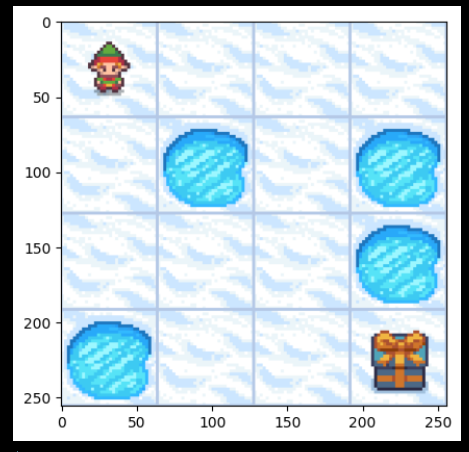

### Finally, let's allow our Q-learning -based AI to play the game with the optimized Q-table!

In [ ]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)


        # Logging state, action, and Q-value
        print(f"Step {step + 1}:")
        print(f"  State: {state}")
        print(f"  Action: {action}")
        print(f"  Q-value: {Q_table[state, action]:.4f}")
        print(f"  Next Observation: {observation}")
        print(f"  Reward: {reward}\n")
        print(f"  Q-values row: {Q_table[state]}\n")
        # Print current step info
        print(f"Step {step+1}: State={state}, Action={action}, Q-values={Q_table[state]}")
        
        results = summarize_best_values(Q_table, grid_width, grid_height)
        df = pd.DataFrame(results)
        print(df)

        time.sleep(5.3)
        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)     
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done or truncated:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(1.3)

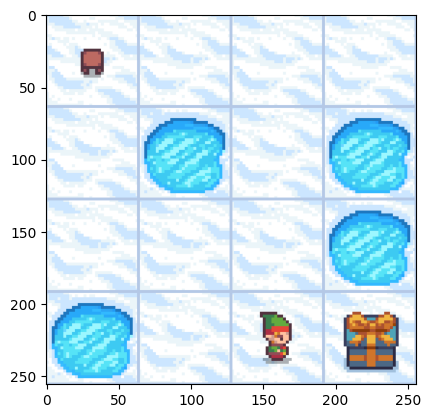

### Lets see Q table with values and moves with observation in each step!

# Step 1


In [ ]:
# there is state 0 and agent will move from there there agent took action 1, means start to step down which is which is down 
# and value is 0.6591 there next observation is 4. but he could not get any rewards at this point.
# Though it can go right as well, but its a randome selection, and decided possibly best move by the agent.
# Row 0, column 1 (value 0.716393) means: in state 0, taking action 1 (down) has that Q-value.

# Step 2

In [ ]:
# there is state 4 which is represt the current position of the agent its mean 2nd row and first colum where agent is now.
# There agent chose action 1 again, it means it decide again to go down for more heigh predictable step. 
# and value is 0.7164 Q-value for taking action 1 in state 4. It's the expected future reward
# There is again new observation value which is state 8 , After taking the action 1, the agent landed in state 8.
# There was right value 0.0000 , thereby it chose the action 1 go down which was the heigher value then right one.
# but its a randome selection, and decided possibly best move by the agent.
# No reward yet (likely not at the goal state or a hole).

# Step 3 and 4

In [ ]:
# Step 3
# Current State: 8 (2nd row, 1st column in the grid) Action Taken: 2 (Right)
# Q-value Before Update: 0.7787 and Next State (Observation): 9 (2nd row, 2nd column)
# still there is no reward which is 0.0
# At this point, the agent decides to move right from state 8 to state 9. There's no immediate reward,
# but the Q-value is updated based on the expected future reward in state 9.

# Step 4 based on next observation value 
# Current State: 9 (after moving right) Action Taken: 1 (Down) Q-value ,Before Update: 0.8464 
# and Next State (Observation): 13 (3rd row, 2nd column) , Reward: 0.0
# Now in state 9, the agent chooses to move down, heading further toward the goal. Again, there’s no reward yet, but it’s likely trying to reach a terminal state.

# Step 5 and Final step

In [ ]:
# Step 5
# State: 13 and Action Taken: 2 (assumed to be "right") and  Q-value: 0.9200 along with this Next State (Observation): 14
# Q-values row for state 13:[0. 0.8464 0.9200 0.778688] This indicates the Q-values for each action from state 13
# see state 13 corresponds to the third row, third column in the flattened version (assuming row-major order)
# still there is no reward which is 0.0.
# Step 6 and final step based on next observation value 
# State: 14, Action Taken: 2 (again, "right"), Q-value: 1.0000, Next Observation: 15, Reward: 1.0 (goal reached!)
# Q-values row for state 14: [0.8464 0.92 1.0 0.8464], Now the value of taking action 2 from state 14 is maximized—reward of 1 reached.
# The agent starts at state 13, moves right to 14, then again right to 15 (goal).
# Q-values are updated as the agent learns, reflecting higher confidence in actions leading to the reward
# The reward of 1.0 appears only when reaching the gift at state 15.
# Q-values encode learned optimal actions from each state.

# There are 5 episodes and I tried different paratmeres and I found the best optimal 
# solution and rewards by using this appisode and shortest path agent took.
# I did experiments by changing the paratmeters with different values along with changing the numbers of episodes etc